In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [81]:
df = pd.read_csv('03_Cleaned_File(Data Preprocessing).csv')

In [82]:
df.head()

,CustomerId,Surname,CreditScore,Gender,Age,EstimatedSalary,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited,Geography_Germany,Geography_Spain
0,15634602,Hargrave,619,0,42,101348.88,0.00,1,1,2,1,1,0,0
1,15647311,Hill,608,0,41,112542.58,83807.86,1,1,1,1,0,0,1
2,15619304,Onio,502,0,42,113931.57,159660.80,3,0,8,0,1,0,0
3,15701354,Boni,699,0,39,93826.63,0.00,2,0,1,0,0,0,0
4,15737888,Mitchell,850,0,43,79084.10,125510.82,1,1,2,1,0,0,1


In [83]:
X = df.drop(columns = ['CustomerId', 'Surname', 'Exited'])
y = df['Exited']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

In [85]:
num_features = ['CreditScore', 'Age', 'EstimatedSalary', 'Balance']
preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), num_features)],
                                 remainder = 'passthrough',
                                 force_int_remainder_cols=False)

In [86]:
steps = [("preprocess", preprocessor),
         ("ada_boost", AdaBoostClassifier(random_state = 42, estimator = DecisionTreeClassifier(max_depth = 5)))]

In [87]:
steps

[('preprocess',
  ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                    transformers=[('num', StandardScaler(),
                                   ['CreditScore', 'Age', 'EstimatedSalary',
                                    'Balance'])])),
 ('ada_boost',
  AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                     random_state=42))]

In [88]:
pipe = Pipeline(steps)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'EstimatedSalary',
                                                   'Balance'])])),
                ('ada_boost',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                    random_state=42))])

In [89]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'EstimatedSalary',
                                                   'Balance'])])),
                ('ada_boost',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                    random_state=42))])

In [90]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [91]:
param_grid = {
    'ada_boost__n_estimators': [50, 100, 200, 300],
    'ada_boost__learning_rate': [0.001, 0.01, 0.1, 1.0]
}

In [92]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
grid_search = GridSearchCV(estimator = pipe,
                           param_grid = param_grid,
                           scoring = scoring,
                           refit = 'recall',           
                           cv = 5,
)

In [93]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'EstimatedSalary',
                                                                          'Balance'])])),
                                       ('ada_boost',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                                           random_state=42))]),
             param_grid={'ada_boost__learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'ada_boost__n_estimators': [50, 100, 200, 300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [94]:
grid_search.best_params_

{'ada_boost__learning_rate': 0.1, 'ada_boost__n_estimators': 50}

In [95]:
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

In [96]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2281,  108],
       [ 321,  290]], dtype=int64)

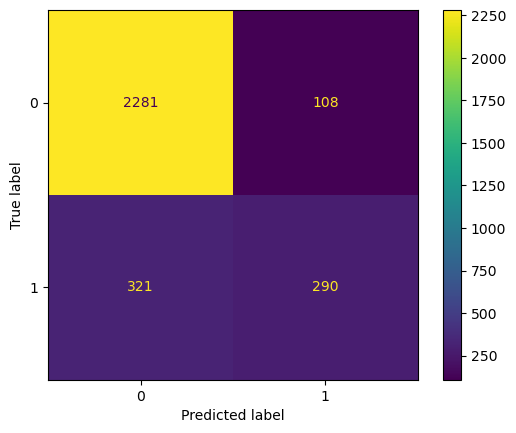

In [97]:
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

In [98]:
class0_accuracy = cm[0,0] / cm[0].sum()
class1_accuracy = cm[1,1] / cm[1].sum()
print(f"Class 0 Accuracy: {class0_accuracy:.2f}")
print(f"Class 1 Accuracy: {class1_accuracy:.2f}")

Class 0 Accuracy: 0.95
Class 1 Accuracy: 0.47


In [99]:
print(f'Accuracy : {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision : {precision_score(y_test, y_pred):.2f}')
print(f'Recall : {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score : {f1_score(y_test, y_pred):.2f}')

Accuracy : 0.86
Precision : 0.73
Recall : 0.47
F1 Score : 0.57


In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2389
           1       0.73      0.47      0.57       611

    accuracy                           0.86      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.85      0.86      0.84      3000

